## Build MRCNN Model
Pass data through MRCNN and then FCN and investigte output values from FCN
- First we generate the heatmaps, and also visually cehck them. 
- the we pass the heatmaps to the routine that prodcues the scores 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')
import tensorflow          as tf
import keras.backend       as KB
import numpy               as np
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf, log
from mrcnn.visualize       import display_gt_bboxes, display_roi_proposals, plot_3d_heatmap 
from mrcnn.visualize       import display_gt_bboxes, display_roi_proposals
from mrcnn.prep_notebook   import mrcnn_coco_train, prep_coco_dataset
from mrcnn.coco            import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results

import mrcnn.visualize     as visualize
from mrcnn.visualize       import (plot_one_bbox_heatmap, 
                             plot_3d_heatmap, plot_2d_heatmap, 
                             plot_3d_heatmap_all_classes, plot_2d_heatmap_all_classes,
                             plot_2d_heatmap_compare, plot_3d_heatmap_compare)
import matplotlib as plt
%matplotlib inline

import mrcnn.model_fcn     as fcn_modellib
import mrcnn.model_mrcnn   as mrcnn_modellib
import mrcnn.utils         as utils

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

mrcnn_model, mrcnn_config = mrcnn_coco_train(mode = 'trainfcn')

# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
mrcnn_model.load_model_weights(init_with = 'last', exclude = None)  

##  Build FCN Model 

####  FCN configuration

from mrcnn.utils import Paths
paths = Paths(fcn_training_folder='train_fcn8_coco')
paths.display()
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
# mrcnn_config.COCO_DATASET_PATH  = COCO_DATASET_PATH 
# mrcnn_config.COCO_MODEL_PATH    = COCO_MODEL_PATH   
# mrcnn_config.RESNET_MODEL_PATH  = RESNET_MODEL_PATH 
fcn_config.NAME                 = 'fcn'              
fcn_config.TRAINING_PATH        = paths.FCN_TRAINING_PATH
fcn_config.VGG16_MODEL_PATH     = paths.FCN_VGG16_MODEL_PATH
fcn_config.FCN_INPUT_SHAPE      = mrcnn_config.IMAGE_SHAPE[0:2] // mrcnn_config.HEATMAP_SCALE_FACTOR 

fcn_config.BATCH_SIZE           = mrcnn_config.BATCH_SIZE                # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = mrcnn_config.BATCH_SIZE                  # Must match BATCH_SIZE
fcn_config.EPOCHS_TO_RUN        = 1
fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.LAST_EPOCH_RAN       = 0

fcn_config.LEARNING_RATE        = 0.0001 

fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 5
fcn_config.REDUCE_LR_PATIENCE   = 5
fcn_config.EARLY_STOP_PATIENCE  = 15
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
 
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-6
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'

fcn_config.display()

#### Build FCN Model

##------------------------------------------------------------------------------------
## Build FCN Model in Training Mode
##------------------------------------------------------------------------------------
try :
    del fcn_model
    gc.collect()
except: 
    pass    
fcn_model = fcn_modellib.FCN(mode="training", arch = 'FCN8', config=fcn_config)

####  Display FCN model info

# fcn_model.config.display()  
fcn_model.layer_info()

Using TensorFlow backend.


>>> Initialize Paths
 Linx  Linux

Paths:
-------------------------
COCO_DATASET_PATH              /home/kbardool/MLDatasets/coco2014
COCO_MODEL_PATH                /home/kbardool/PretrainedModels/mask_rcnn_coco.h5
DIR_DATASET                    /home/kbardool/MLDatasets
DIR_PRETRAINED                 /home/kbardool/PretrainedModels
DIR_ROOT                       /home/kbardool/git_projs/mrcnn3/notebooks
DIR_TRAINING                   /home/kbardool/models
FCN_TRAINING_PATH              /home/kbardool/models/train_fcn_coco
FCN_VGG16_MODEL_PATH           /home/kbardool/PretrainedModels/fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5
MRCNN_TRAINING_PATH            /home/kbardool/models/train_mrcnn_coco
RESNET_MODEL_PATH              /home/kbardool/PretrainedModels/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
VGG16_MODEL_PATH               /home/kbardool/PretrainedModels/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


>>> Initialize ModelBase model 
   Mode      :  trainfcn
  

     Prob_grid shape :  (?, 256, 256)
    prob_grid_clipped      :  (?, 256, 256)
    scores_scattered shape :  (1, 81, 200, 3)
    gauss_scores           :  (1, 81, 200, 11)  Name:    cntxt_layer_gt/gt_heatmap_scores:0
    gauss_scores  (FINAL)  :  (1, 81, 200, 11)  Keras tensor  False

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 256, 256)
    gauss_heatmap   :  (1, 81, 200, 256, 256)

    Reduce MAX based on class ---------------------------------------------
    gaussian_heatmap :  (1, 81, 256, 256) Keras tensor  False
    gauss_heatmap :  (1, 256, 256, 81)  Keras tensor  False

    gt_heatmap                  :  (1, 256, 256, 81) Keras tensor  False
    gt_heatmap_scores           :  (1, 81, 200, 11) Keras tensor  False
    complete
<<<  shape of pred_heatmap   :  (1, 256, 256, 81)  Keras tensor  True
<<<  shape of gt_heatmap     :  (1, 256, 256, 81)  Keras tensor  True

>>> Build MaskRCNN buil

   FCN conv2d (fcn32_deconv2D) shape   :  (?, 8, 8, 81)  keras_tensor  True

   --- FCN16 ----------------------------
   FCN scorePool4 (Conv2D(Pool4)) shape is                   :  (None, 16, 16, 81)    keras_tensor  True
   FCN 2x Upsampling (Deconvolution2D(fcn32_classify)) shape :  (None, 18, 18, 81)    keras_tensor  True
   FCN 2x Upsampling/Cropped (Cropped2D(score2)) shape       :  (None, 16, 16, 81)    keras_tensor  True
   FCN Add Score2,scorePool4 Add(score2_c, scorePool4) shape :  (None, 16, 16, 81)    keras_tensor  True
   FCN upscore_pool4 (Deconv(fuse_Pool4)) shape              :  (None, 32, 32, 81)    keras_tensor  True

   --- FCN8 ----------------------------
   FCN scorePool4 (Conv2D(Pool4)) shape                      :  (None, 32, 32, 81)    keras_tensor  True
   FCN 2x Upsampling/Cropped (Cropped2D(score2)) shape       :  (None, 32, 32, 81)    keras_tensor  True
   FCN Add Score2,scorePool4 shape is                        :  (None, 32, 32, 81)    keras_tensor  True

## LoadFCN weights (FCN weights if not starting from init mode)

In [11]:
##------------------------------------------------------------------------------------
## Load FCN Model weights  
##------------------------------------------------------------------------------------
# fcn_model.load_model_weights(init_with = 'last') # 'fcn_config.VGG16_MODEL_PATH')
# WEIGHT_FILE = '/home/kbardool/models/train_fcn8_coco/fcn20181028T0000/fcn_0050.h5'  # <--- With L2
# WEIGHT_FILE = '/home/kbardool/models/train_fcn8_coco/fcn20181030T0000/fcn_0248.h5' # <--- Partial L2 (some still remaining)
WEIGHT_FILE = '/home/kbardool/models/train_fcn8_coco/fcn20181031T0000/fcn_0256.h5'
fcn_model.load_model_weights(init_with =WEIGHT_FILE, verbose = 1)


-----------------------------------------------
 Load Model with init parm: [ last ]
-----------------------------------------------
 ---> last
>>> find_last checkpoint in :  /home/kbardool/models/train_mrcnn_coco
    Key : > mrcnn <
    Dir names:  ['mrcnn20181105T1801', 'mrcnn20181105T1811', 'mrcnn20181105T1813', 'mrcnn20181011T1100']
    Folder:  /home/kbardool/models/train_mrcnn_coco/mrcnn20181105T1813
    Checkpoints:  []
    Folder:  /home/kbardool/models/train_mrcnn_coco/mrcnn20181105T1811
    Checkpoints:  []
    Folder:  /home/kbardool/models/train_mrcnn_coco/mrcnn20181105T1801
    Checkpoints:  []
    Folder:  /home/kbardool/models/train_mrcnn_coco/mrcnn20181011T1100
    Checkpoints:  ['mrcnn_0103.h5']
    find_last():   dir_name: /home/kbardool/models/train_mrcnn_coco/mrcnn20181011T1100
    find_  last(): checkpoint: /home/kbardool/models/train_mrcnn_coco/mrcnn20181011T1100/mrcnn_0103.h5
   Last file is : /home/kbardool/models/train_mrcnn_coco/mrcnn20181011T1100/mrcnn_0103.h

   Weights file loaded: /home/kbardool/models/train_fcn8_coco/fcn20181031T0000/fcn_0256.h5 
FCN  MODEL Load weight file COMPLETE 


## Load Training Files and Display Images
 
     train
         image_ids[:10]       :  [262145, 262146, 524291, 131074, 393221, 131075, 393223, 393224, 524297, 9]
         image_ids[1000:1010] :  [1451, 132523, 1453, 132527, 263599, 132529, 132528, 263603, 263604, 132533]
     val35k
      image_ids[:10]       :  [262148, 393225, 131089, 262161, 262162, 393243, 262175, 131108, 393254, 42]
      image_ids[1000:1010] :  [134290, 527506, 527504, 134288, 527510, 265372, 265374, 265378, 527529, 3244]

In [3]:
# dataset_train, train_generator  = prep_coco_dataset(['train','val35k'], mrcnn_config, generator = True)
dataset_train, train_generator  = prep_coco_dataset(['train','val35k'], mrcnn_config, generator = True)
# dataset_val, val_generator      = prep_coco_dataset(['minival'], mrcnn_config, generator = True) 
class_names = dataset_train.class_names

loading annotations into memory...
Done (t=11.83s)
creating index...
index created!
 image dir            :  /home/kbardool/MLDatasets/coco2014/train2014
 json_path_dir        :  /home/kbardool/MLDatasets/coco2014/annotations/instances_train2014.json
 number of images     :  82081
 image_ids[:10]       :  [262145, 262146, 524291, 131074, 393221, 131075, 393223, 393224, 524297, 9]
 image_ids[1000:1010] :  [1451, 132523, 1453, 132527, 263599, 132529, 132528, 263603, 263604, 132533]
loading annotations into memory...
Done (t=11.34s)
creating index...
index created!
 image dir            :  /home/kbardool/MLDatasets/coco2014/val2014
 json_path_dir        :  /home/kbardool/MLDatasets/coco2014/annotations/instances_valminusminival2014.json
 number of images     :  35185
 image_ids[:10]       :  [262148, 393225, 131089, 262161, 262162, 393243, 262175, 131108, 393254, 42]
 image_ids[1000:1010] :  [134290, 527506, 527504, 134288, 527510, 265372, 265374, 265378, 527529, 3244]


####  Display next image from generator

In [4]:
train_batch_x, train_batch_y = next(train_generator)

Image id:  12902
Image meta [12902   640   444     3     0   157  1024   867     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1]


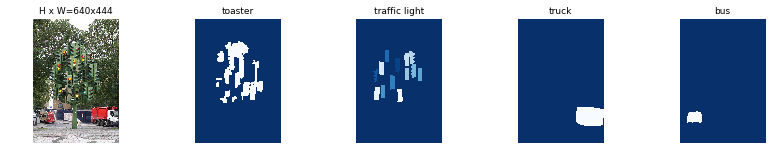

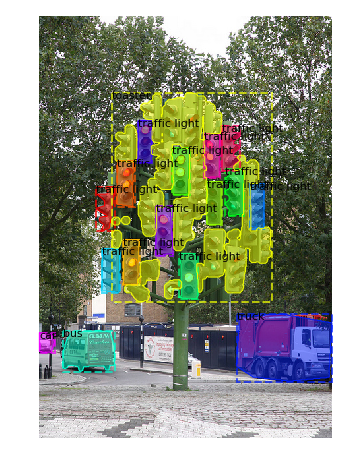

In [12]:
class_names = dataset_train.class_names
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
#     print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))  

#### Load a specific image using image_id

In [ ]:
## 62642 (persons),   68539 (trucks) 36466 (surfers)  75040 (boat and persons)
## 36466 surfers. 5498 basketbal players, 27711,30531
## 5498 lots of motorcylces & persons - 
## Persons: #26026, #7719, 111864, 58240,  
## 89243: Person, bicylce and traiffic lights
## 35347 - laptops, keyboards and cat
## items = [59199 , 102868]
## 101623 (cake and forks), 41423 (elephant & people)
## 33477 Table, bowl, cup, sandwich, knife
## 26763 Table, chair, cup , bowl, bottle
## 49316 Table, book, backpack, many bottles
# train_batch_x, train_batch_y = next(train_generator)
# IMAGE_LIST = [75040] 
# IMAGE_LIST = [89243]
# IMAGE_LIST = [33477]
# IMAGE_LIST = [29731]
IMAGE_LIST = [26763]
train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_config, IMAGE_LIST)
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
    print(' Dataset coco file:', dataset_train.image_info[image_id]['id'])
    print(' Image meta  : ', img_meta[img_idx,:10])
    print(' Classes     : ', class_ids)
    print(" Image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
    print(' Class_ids.shape[0]:', class_ids.shape[0], 'bbox.shape[0]:',bbox.shape[0])       
    print(' Class Names : ', class_names)
    
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)   
    # Display image and instances
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))    

## Pass image through MRCNN and FCN

In [13]:
# mrcnn_model.layer_info()

# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3], 1)

### Load input / output data

print(len(model_output))
# del pred_heatmap_norm, pred_heatmap_scores, gt_heatmap, gt_heatmap_scores
model_pred_heatmap_norm         = model_output[0]          # layer:  0   shape: (1, 256, 256, 81)
model_pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (1, 81, 200, 11)
model_gt_heatmap                = model_output[2]          # layer:  2   shape: (1, 256, 256, 81)
model_gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (1, 81, 200, 11)

for i in model_output:
    print( i.shape)

# input_image      =  train_batch_x[0]
input_image_meta =  train_batch_x[1]
input_gt_bboxes  =  train_batch_x[5]
print(input_image_meta)

### Pass data through FCN

# fcn_model.layer_info()
fcn_train_batch_x = [train_batch_x[1]]
fcn_train_batch_x.extend(model_output[:4])
for i in fcn_train_batch_x:
    print(i.shape)
# fcn_train_batch_x = [model_pred_heatmap_norm, model_pred_heatmap_scores, model_gt_heatmap, model_gt_heatmap_scores]

fcn_model_output = get_layer_output_1(fcn_model.keras_model, fcn_train_batch_x, [0,1], 1)
 

model_fcn_heatmap               = fcn_model_output[0]          # layer:  0   shape: (1, 256, 256, 81)
model_Mean                      = fcn_model_output[1]          # layer:  1   shape: ()

# hm_sum = np.sum(model_fcn_heatmap, axis=(1,2))
print('FCN heatmap shape: ', model_fcn_heatmap.shape)
print('FCN heatmap loss : ', model_Mean)

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 261888, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)

/* Outputs */
Output idx:  0    Layer:  0: (cntxt_layer/pred_heatmap_norm:0         ) 	  Output shape: (1, 256, 256, 81)
Output idx:  1    Layer:  1: (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (1, 81, 200, 11)
Output idx:  2    Layer:  2: (cntxt_layer_gt/gt_heatmap:0             ) 	  Output shape: (1, 256, 256, 81)
Output idx:  3    Layer:  3: (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Output shape: (1, 81, 200, 11)

Number of layers generated:  4 

pred_heatmap_norm

#### Display values from FCN_heatmap

In [ ]:
img_id = 0 
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
for i in range(class_ids[-1]+1):
    
    print('FCN class: {:3d}   min: {:12.8f}    max: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_fcn_heatmap[0,:,:,i]), 
                                                                    np.max(model_fcn_heatmap[0,:,:,i]), 
                                                                    np.sum(model_fcn_heatmap[0,:,:,i])))
    print('GT  class: {:3d}   min: {:12.8f}    max: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_gt_heatmap[0,:,:,i]), 
                                                                    np.max(model_gt_heatmap[0,:,:,i]), 
                                                                    np.sum(model_gt_heatmap[0,:,:,i])))
    print()

In [ ]:
# print(model_fcn_heatmap[0,0:10,:10,1])

In [ ]:
# for i in range(10):
#     print(model_fcn_heatmap[0,i,:,4])
#     print(np.min(model_fcn_heatmap[0,i,:,1]), np.max(model_fcn_heatmap[0,i,:,1]))

## Display Heatmaps

In [14]:
# from mrcnn.visualize import (plot_one_bbox_heatmap, 
#                              plot_3d_heatmap, plot_2d_heatmap, 
#                              plot_3d_heatmap_all_classes, plot_2d_heatmap_all_classes,
#                              plot_2d_heatmap_compare, plot_3d_heatmap_compare)
# import matplotlib as plt
# %matplotlib inline
print('Image id: ',image_id, ' Coco ID: ', dataset_train.image_info[image_id]['id'])
img_id = 0
coco_class_names = dataset_train.class_names

Image id:  12902  Coco ID:  18513


### 2D Plots  

####  2D plot of `model_gt_heatmap` returned from model

(1, 256, 256, 81) (1, 81, 200, 11)
Image : 0  ClassIds: [0, 3, 6, 8, 10]
Display classes: [0, 3, 6, 8, 10]
rows   3  columns : 2


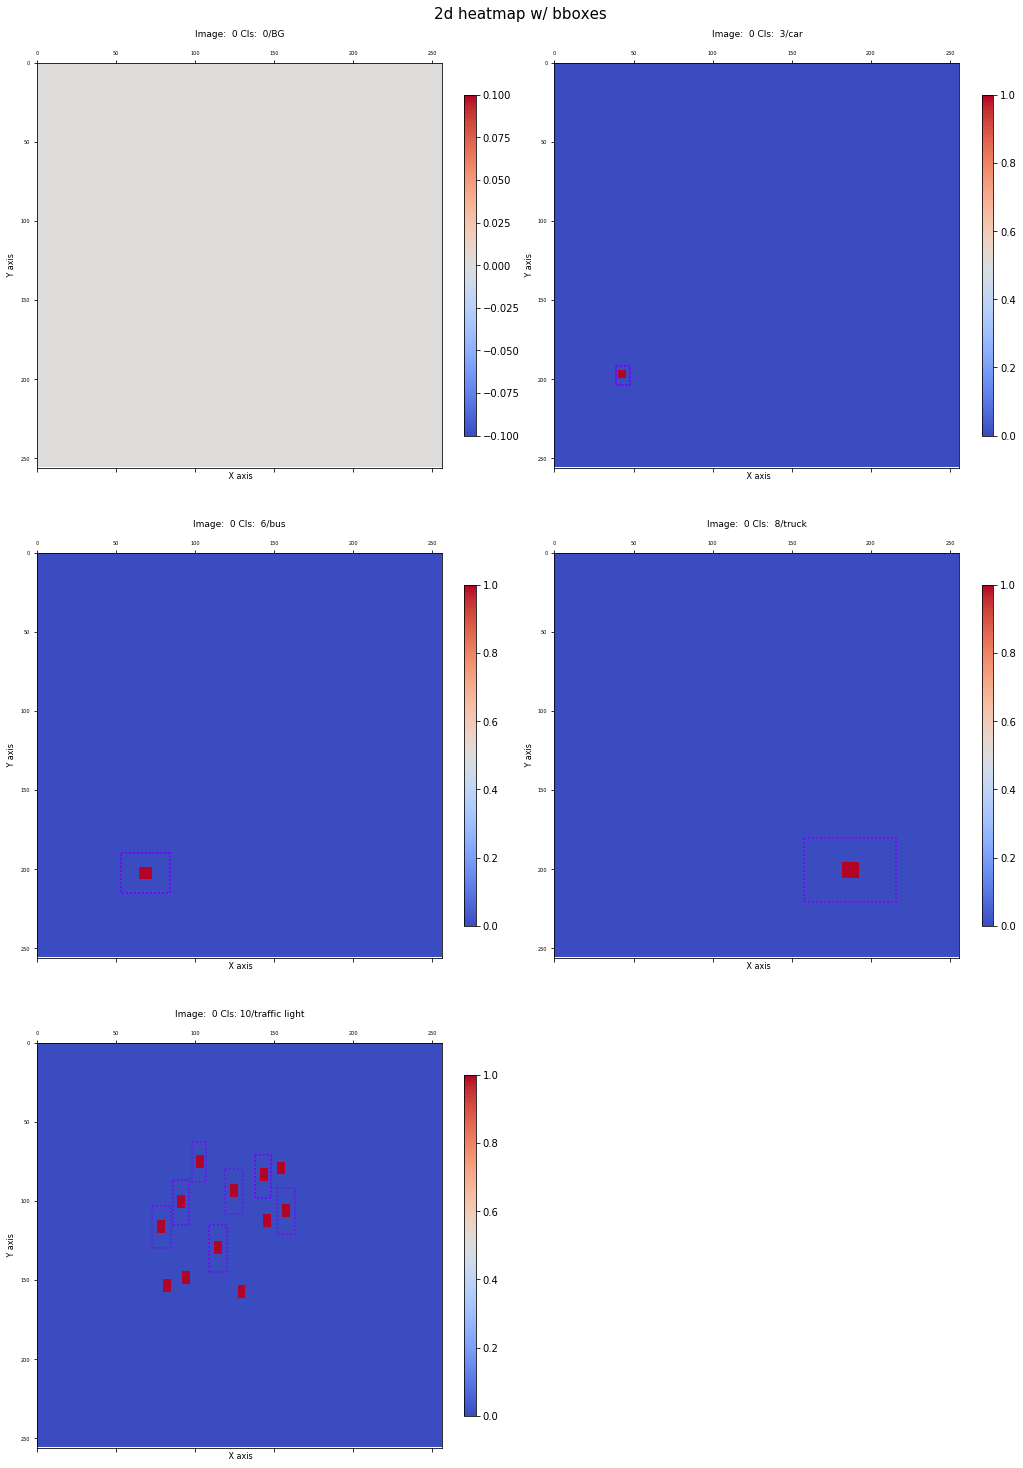

In [15]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape, model_gt_heatmap_scores.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap(model_gt_heatmap, model_gt_heatmap_scores, img_id, class_ids, 
                     class_names = coco_class_names, columns = 2, scale = 4)

####  2D plot of `pred_heatmap_norm` returned from MRCNN 

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 3, 8, 10]
Display classes: [0, 3, 8, 10]
rows   2  columns : 2


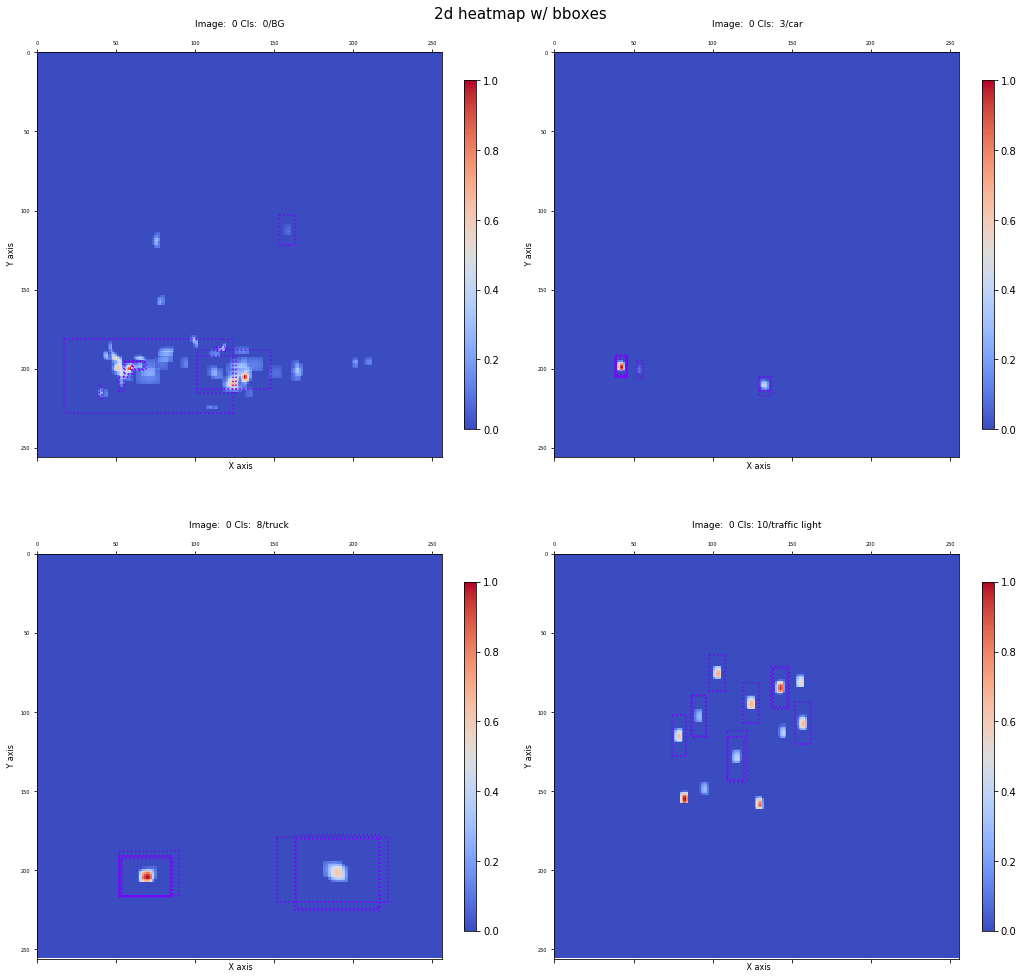

In [16]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap(model_pred_heatmap_norm, model_pred_heatmap_scores, img_id, class_ids, 
                                class_names = class_names, size = (7,7), scale = 4)

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 3, 8, 10]
Display classes: [0, 3, 8, 10]
rows   2  columns : 2


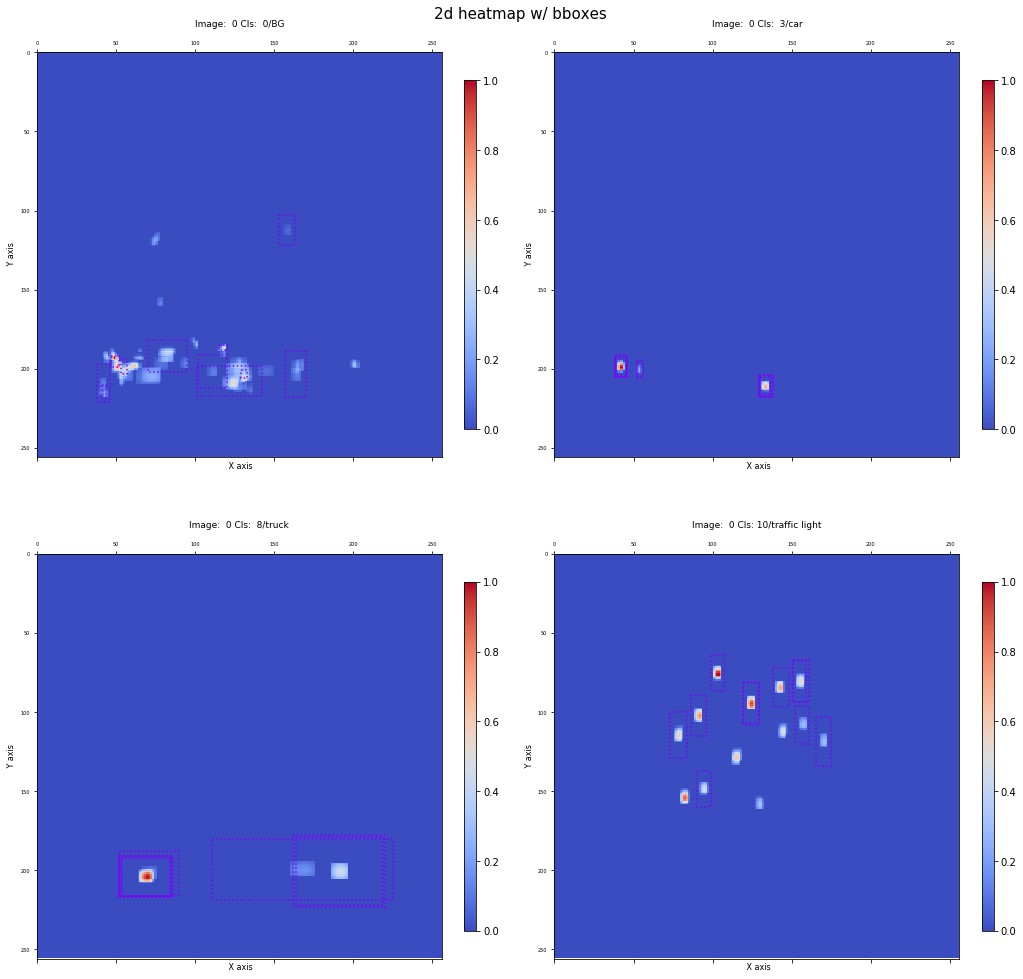

In [9]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap(model_pred_heatmap_norm, model_pred_heatmap_scores, img_id, class_ids, 
                                class_names = class_names, size = (7,7), scale = 4)

####  2D plot of `model_fcn_heatmap` returned from model

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 3, 6, 8, 10, 1]
Display classes: [0, 3, 6, 8, 10, 1]
class_ids: [0, 1, 3, 6, 8, 10]
rows   2  columns : 3


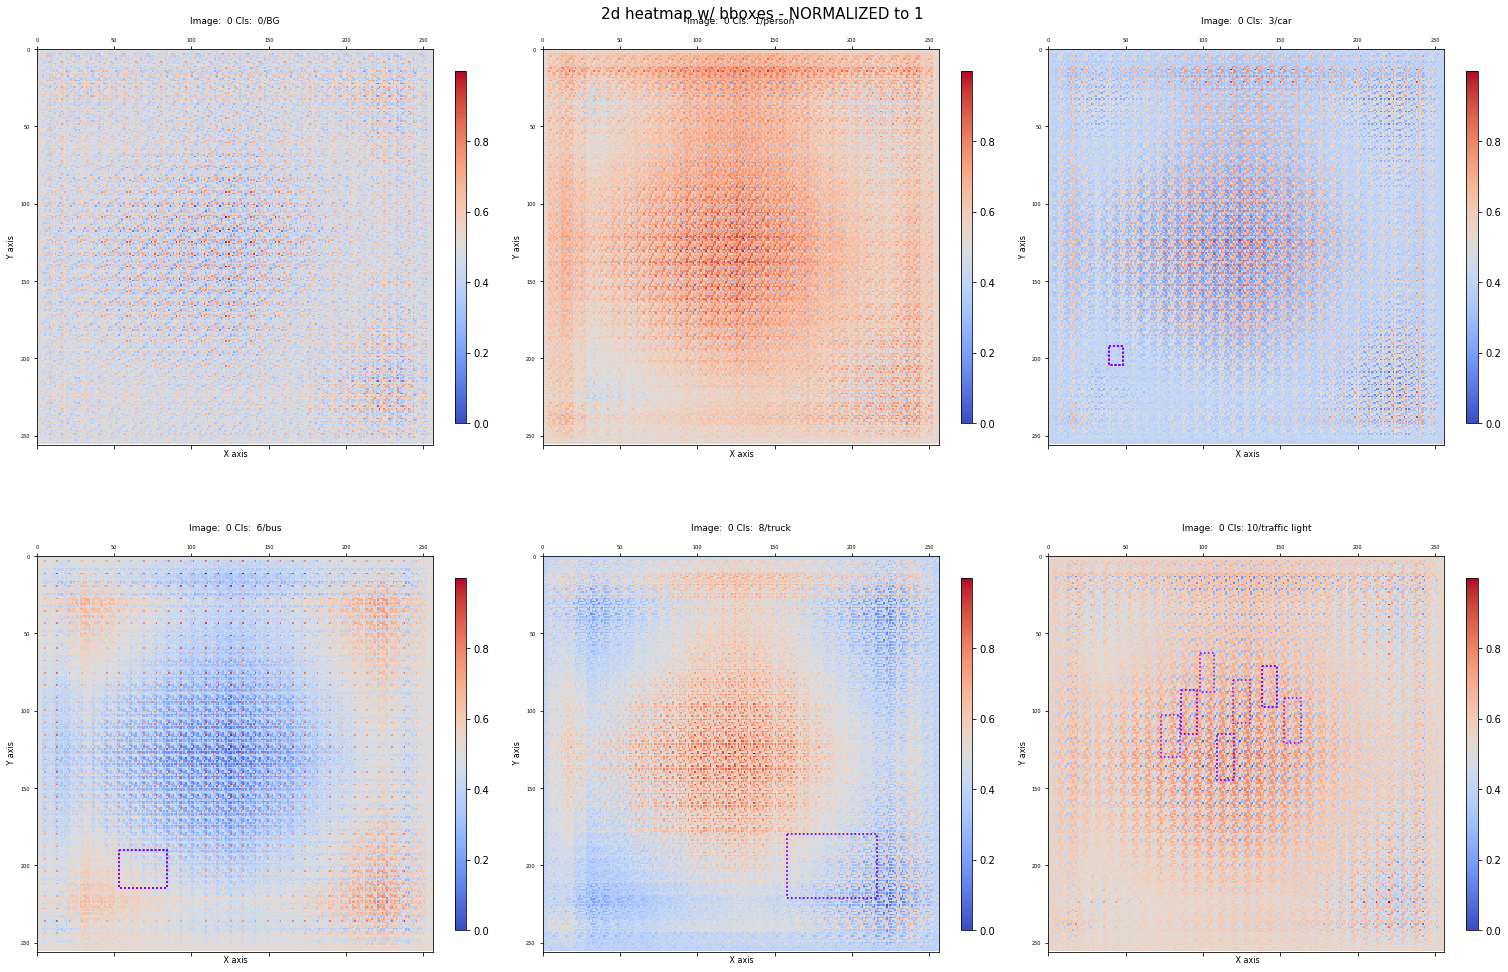

In [56]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    class_ids.append(1) 
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap(model_fcn_heatmap, model_gt_heatmap_scores,img_id, class_ids = class_ids, columns = 3,
                                 class_names = coco_class_names, scale = 4, scaling = True)

####  2D plot of `model_fcn_heatmap` returned from model - ALL CLASSES

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  Pred ClassIds: {}'.format(img_id, class_ids))
    print('            Gt   ClassIds: {}'.format(np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()))
#     plot_2d_heatmap_with_bboxes(model_fcn_heatmap[...,:class_ids[-1]+1], model_gt_heatmap_scores, img_id, 
#                                 class_ids, class_names = class_names, columns = 2, scale = 4)
    fig = plot_2d_heatmap(model_fcn_heatmap, model_gt_heatmap_scores, img_id,
                                class_names = class_names, columns = 4, scale = 4, scaling = True)
#     fig.savefig('fcn_heatmaps_2d.png')

In [ ]:
fig.savefig('fcn_heatmaps_2d.png')

####  2D comparative display `pred_heatmap` / `fcn_heatmap`  

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
#     class_ids = list(range(30))
    plot_2d_heatmap_compare(model_pred_heatmap_norm, model_fcn_heatmap, model_pred_heatmap_scores, img_id, 
                            img_id, class_ids = class_ids, class_names = coco_class_names, scale = 4, scaling = True )    

###  3D Plots

####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_gt_heatmap, img_id, class_ids, class_names = class_names)


####  3D plot of `pred_heatmap_norm` returned form model

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, class_ids, class_names = class_names, zlim = 'all' )


####  3D plot of `fcn_heatmap` returned form model - only classes in pred_scores

In [ ]:
print(np.max(model_fcn_heatmap), np.min(model_fcn_heatmap))

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = coco_class_names, scaling = False)


####  3D plot of `fcn_heatmap` returned form model - all classes

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
#     plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = class_names, size = (8,8), zlim=0)
#     plot_3d_heatmap_all_classes(model_fcn_heatmap[...,:class_ids[-1]+1], img_id, class_names = class_names, size = (8,8), zlim=0.0)
    plot_3d_heatmap(model_fcn_heatmap, img_id, class_names = class_names, columns = 2,scaling = True)

####  3D comparative display `pred_heatmap` / `fcn_heatmap` 

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    class_ids.append(1)
    class_ids = list(range(30))
#     print(class_ids)
    plot_3d_heatmap_compare(model_pred_heatmap_norm,model_fcn_heatmap, img_id, class_ids = class_ids, 
                            class_names = class_names, size=(8,8), zlim = 'all' , scaling = True)

####  3D comparative display `gt_heatmap` / `fcn_heatmap` 

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    class_ids.extend([1,2])
    print(class_ids)
    print(type(class_ids))
    class_ids.sort()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap_compare(model_gt_heatmap,model_fcn_heatmap, img_id, class_ids, class_names = class_names, size=(8,8), zlim = 0 )

### Overlay predictions on image

#### Overlay image with gt_heatmaps

(1, 81, 200, 11)
class ids:  [0, 3, 6, 8, 10]
gt
Image shape : (1024, 1024, 3)  class_ids: [0, 3, 6, 8, 10]
heatmaps shape: (256, 256, 81) bboxes shape : (81, 200, 4)
1- image    :  (1024, 1024, 3) float32 -123.7 151.1
2- image    :  (1024, 1024, 3) uint8 0 255
3- image    :  (640, 444, 3) uint8 0 255
5- image_bw_arr:  (640, 444) uint8 4 254
 boxes_to_image_domain() 
    Original image shape : [640 444   3]   Image window info: [   0  157 1024  867] 
    Adjustment scale     : [0.625 0.625 0.625 0.625]   Adjustment shift : [  0 157] 
    Adjusted boxes shape : (81, 200, 4) 
x1, x2...shapes: (81, 200) (81, 200) (81, 200) (81, 200) (81, 200) (81, 200)
idx  0  class: 0 row: 0 col: 0 subplot:  1


/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


idx  1  class: 3 row: 0 col: 1 subplot:  2
idx  2  class: 6 row: 1 col: 0 subplot:  3
idx  3  class: 8 row: 1 col: 1 subplot:  4
idx  4  class: 10 row: 2 col: 0 subplot:  5


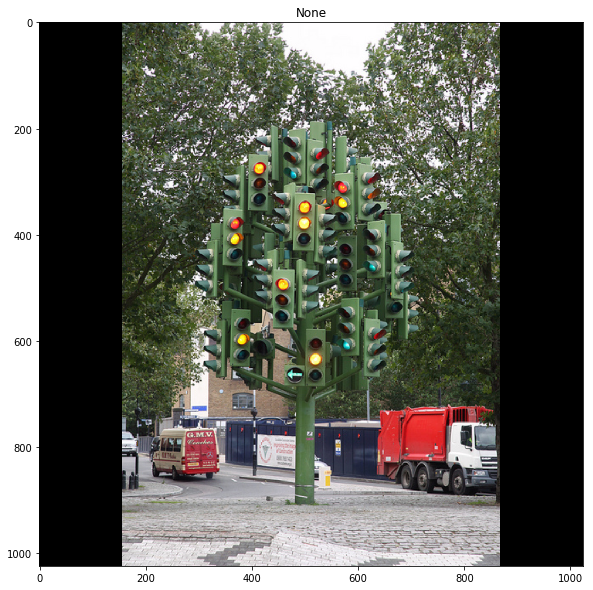

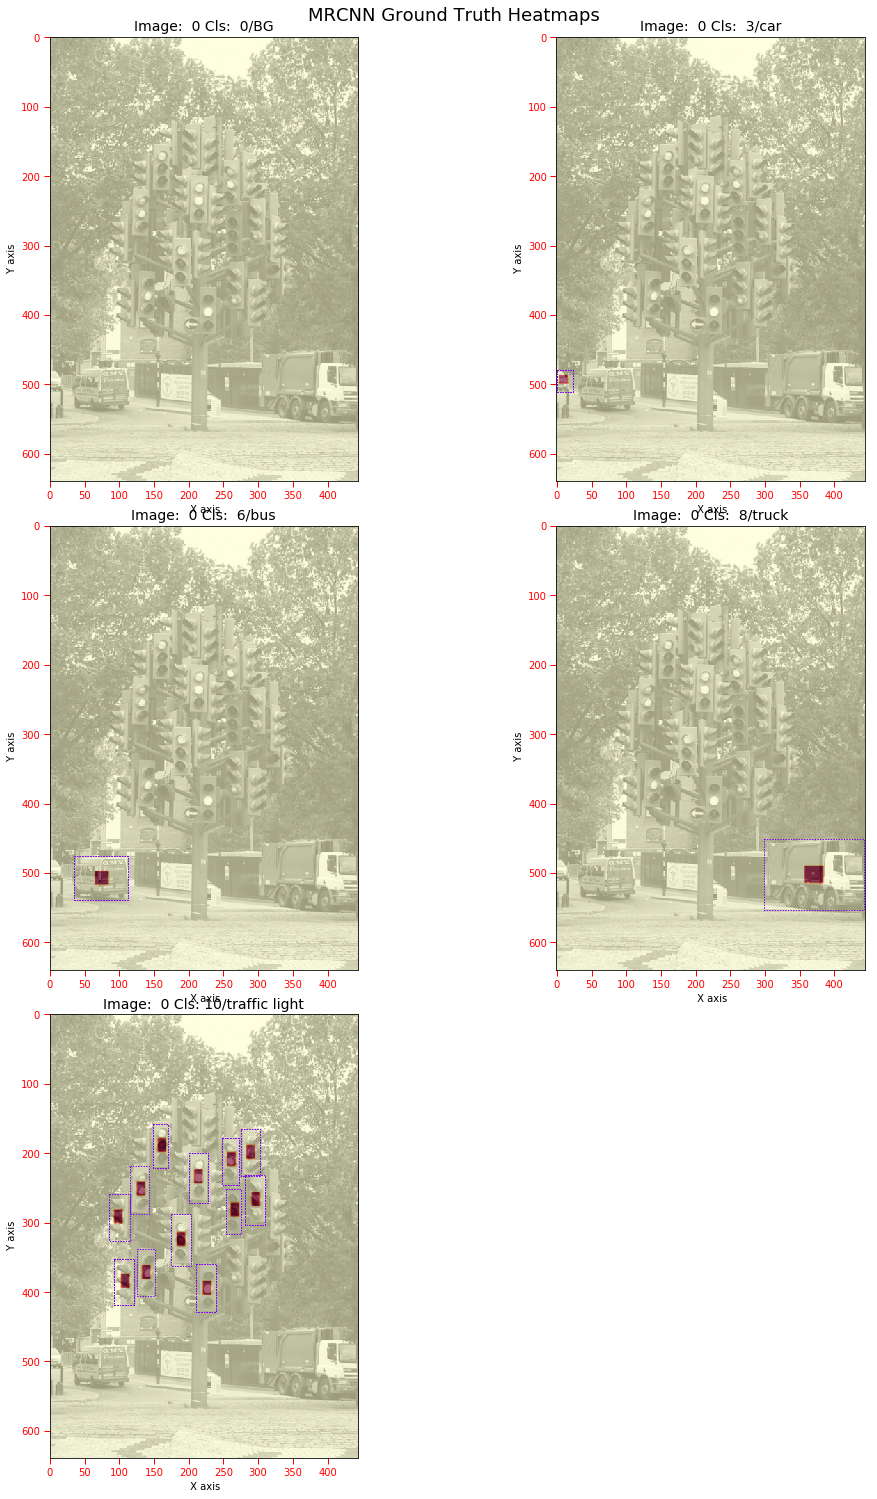

In [34]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)
print(model_gt_heatmap_scores.shape)
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('class ids: ', class_ids)
display_heatmaps_mrcnn(train_batch_x, model_output, 0, hm = 'gt',
                     config = mrcnn_config, class_ids = class_ids, class_names = coco_class_names)

#### Overlay image with pred_heatmaps

(1, 81, 200, 11)
class ids:  [0, 3, 6, 8, 10]
pr
Image shape : (1024, 1024, 3)  class_ids: [0, 3, 6, 8, 10]
heatmaps shape: (256, 256, 81) bboxes shape : (81, 200, 4)
1- image    :  (1024, 1024, 3) float32 -123.7 151.1
2- image    :  (1024, 1024, 3) uint8 0 255
3- image    :  (640, 444, 3) uint8 0 255
5- image_bw_arr:  (640, 444) uint8 4 254
 boxes_to_image_domain() 
    Original image shape : [640 444   3]   Image window info: [   0  157 1024  867] 
    Adjustment scale     : [0.625 0.625 0.625 0.625]   Adjustment shift : [  0 157] 
    Adjusted boxes shape : (81, 200, 4) 
x1, x2...shapes: (81, 200) (81, 200) (81, 200) (81, 200) (81, 200) (81, 200)


/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


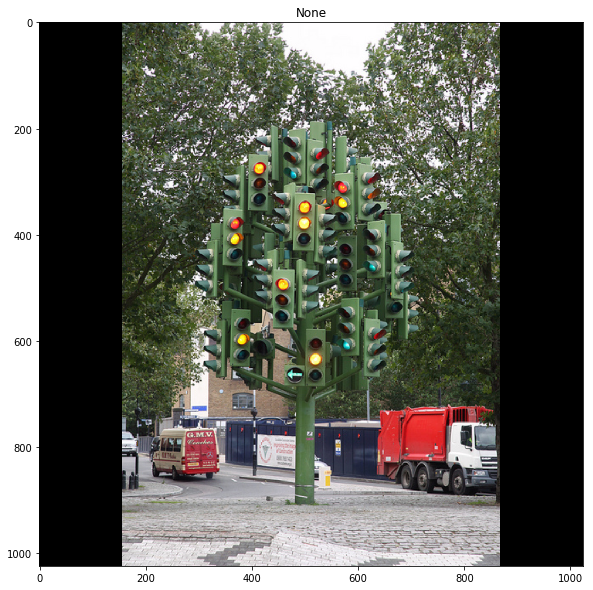

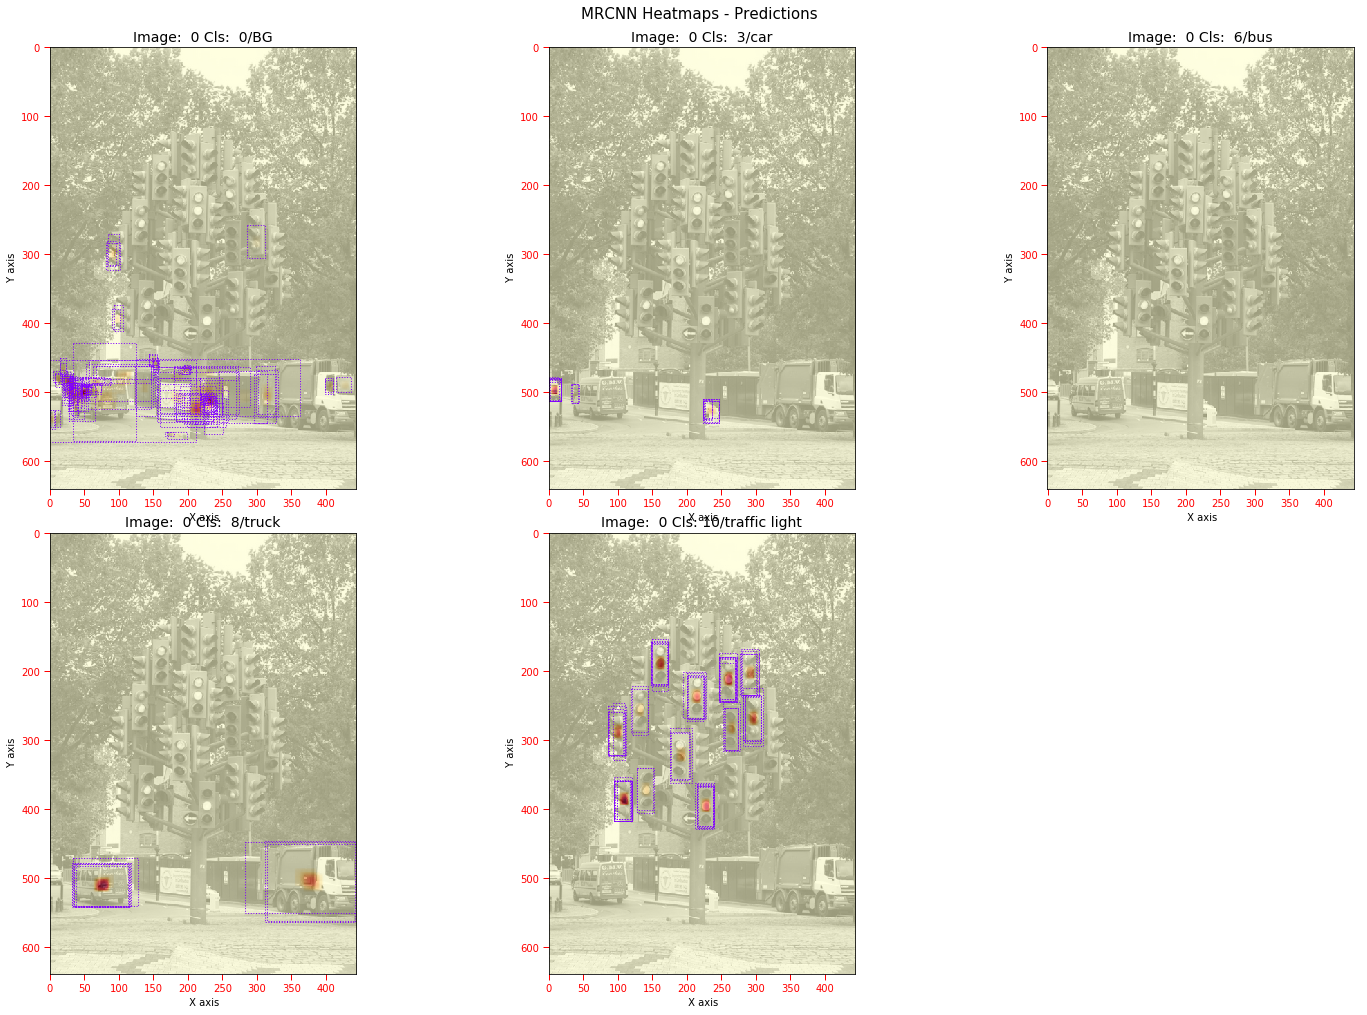

In [40]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)
print(model_gt_heatmap_scores.shape)
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('class ids: ', class_ids)
display_heatmaps_mrcnn(train_batch_x, model_output, 0, hm = 'pr', columns = 3,
                     config = mrcnn_config, class_ids = class_ids, class_names = coco_class_names)

#### Overlay image with fcn_heatmaps

[0, 3, 6, 8, 10]
Image shape : (1024, 1024, 3)  class_ids: [0, 3, 6, 8, 10]
1- image    :  (1024, 1024, 3) float32 -123.7 151.1
2- image    :  (1024, 1024, 3) uint8 0 255
3- image    :  (640, 444, 3) uint8 0 255
4- image_bw_arr:  (640, 444) uint8 4 254
 boxes_to_image_domain() 
    Original image shape : [640 444   3]   Image window info: [   0  157 1024  867] 
    Adjustment scale     : [0.625 0.625 0.625 0.625]   Adjustment shift : [  0 157] 
    Adjusted boxes shape : (81, 200, 4) 
x1, x2...shapes: (81, 200) (81, 200) (81, 200) (81, 200) (81, 200) (81, 200)


/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


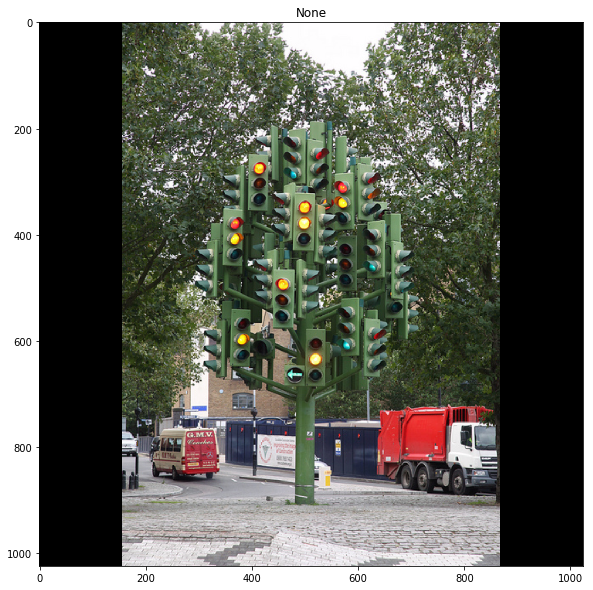

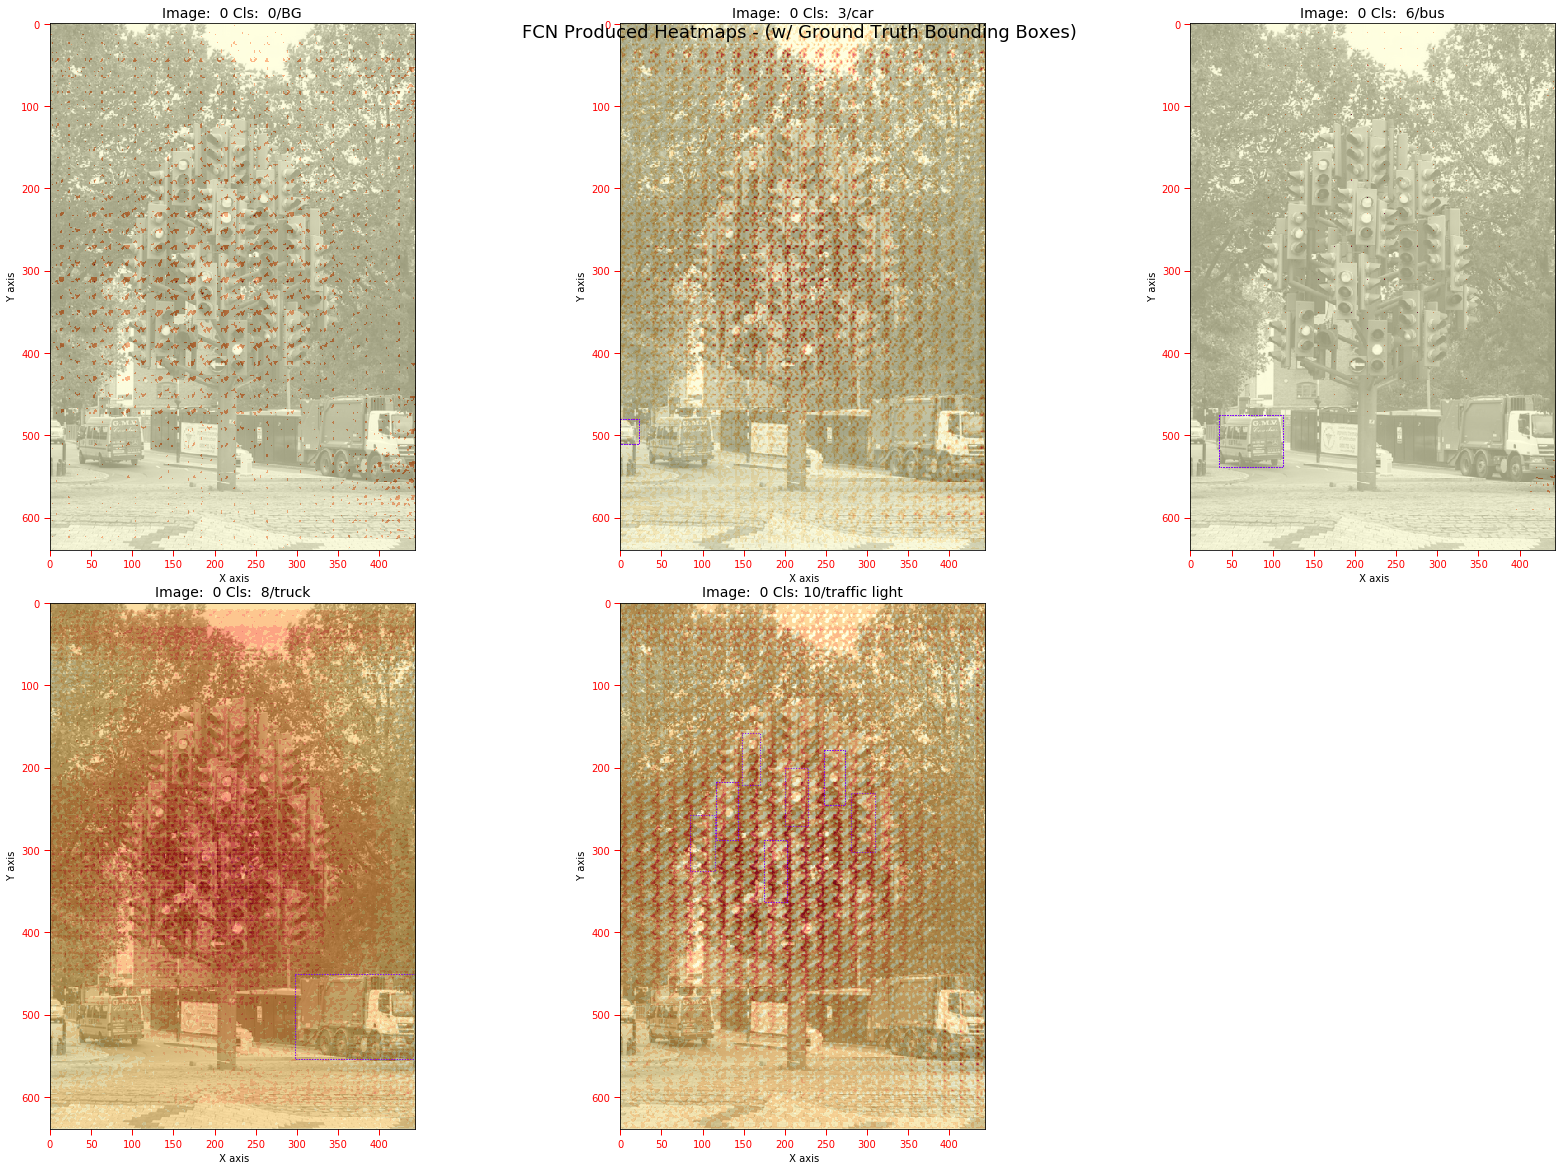

In [39]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn
# visualize.display_image_bw(image)
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print(class_ids)
display_heatmaps_fcn(train_batch_x, fcn_train_batch_x, 0, heatmap = model_fcn_heatmap, hm = 'gt', columns = 3,
                     config = mrcnn_config, class_ids = class_ids, class_names = coco_class_names)

## Review Weight Stats 

In [14]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
# weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[0]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 

### Histograms of Weights 

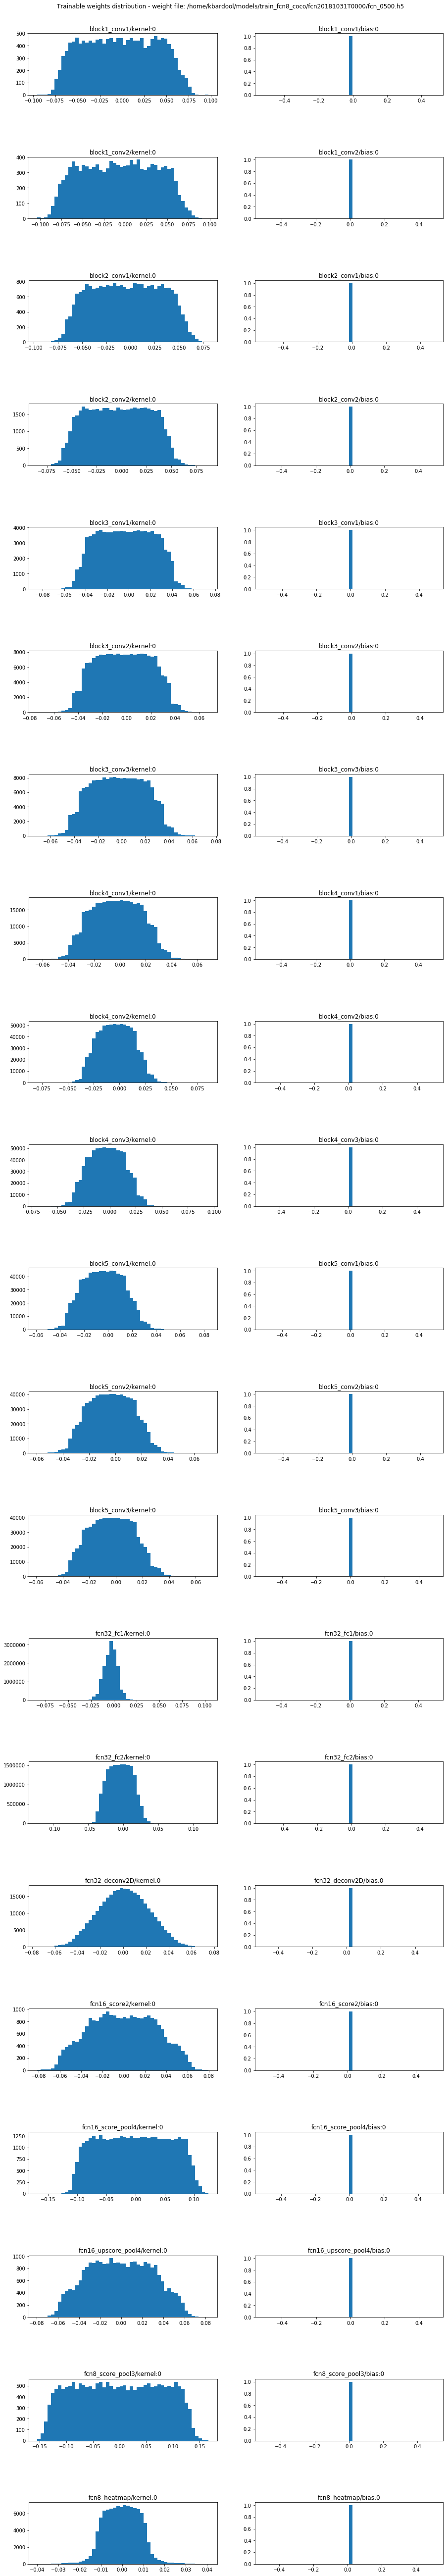

In [17]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = WEIGHT_FILE)
# weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[0]+'.png')
# a.savefig(weights_histogram)

##  Display `gauss_heatmap` 3D heatmap

In [ ]:
from mrcnn.visualize import plot_3d_heatmap, plot_2d_heatmap, plot_3d_gaussian
%matplotlib inline
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
cls = 0
# print(pred_heatmap_scores[img,cls,:10])

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap_norm[img], title = ttl, width = 20)

ttl = 'Ground Truth Non-normalized - image: {}'.format(img)
# plot_3d_gaussian(model_fcn_heatmap[img,:,:,1], title = ttl, width = 10)
# ttl = 'Ground Truth Normalized - image: {}'.format(img)
plot_3d_heatmap(model_fcn_heatmap, 0,[9], title = ttl,width = 10, height=10, zlim=1.0005)


# ttl = 'Non-normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)
# ttl = 'Normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=15, title=ttl)


In [ ]:
from mrcnn.visualize import plot_3d_heatmap, plot_2d_heatmap
%matplotlib inline
img = 0
cls = 1
# print(pred_heatmap_scores[img,cls,:10])

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap_norm[img], title = ttl, width = 20)

ttl = 'FCN - image: {}'.format(img)
plot_3d_heatmap(model_fcn_heatmap, 0,[9], title = ttl, size = (10,10))
ttl = 'Ground Truth Normalized - image: {}'.format(img)
plot_3d_heatmap(model_gt_heatmap,0,[9], title = ttl, size = (10,10))


## Display Input / Output from MRCNN 

####  display Pred_Tensor, Pred_heatmap, mrcnn_class

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=210, suppress=True)
img = 0

# print(KB.int_shape(output_rois))
# print(output_rois[img,:15]*[128, 128,128,128])
# print(input_gt_class_ids[0])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' output_rois')
# print(output_rois.shape)
# print(output_rois[img,:15] * [128, 128,128,128])


# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:15] * [128, 128,128,128])

print(' Pred Heatmap Scores')
print(pred_heatmap_scores.dtype)


print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     for box in range(25):
#         print(pred_heatmap_scores[img,cls,box])
#         print(gt_heatmap_scores[img, cls,box])
#         print()
#     print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 

####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in range(5):
    print('Image ', img , ' ------------')
    print(output_rois[img]*[128,128,128,128])

####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_tensor[img,k])

####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_tensor shape is ', gt_tensor.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_tensor[img,k])

####  Display for visual check - `pred_heatmap_scores` is the final result which is passed from  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

####  Display for visual check - `GT_HEATMAP_SCORES` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_heatmap_scores shape is ', gt_heatmap_scores.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])

####  Display for visual check - `FCN_HEATMAP_SCORES` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, precision=2)
temp = fcn_heatmap_scores
print('fcn_heatmap_scores shape is ', temp.shape)
# img = 1
for img in [1,2,3]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(temp[img,k])
    

####  Display for visual check - `pred_heatmap_norm` is the final result from  `build_gaussian_tf()`

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

####  Display for visual check - `fcn_heatmap is the final result from  `FCN`

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap_norm
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


# sess = KB.get_session()
# with sess.as_default():
#     temp = tf.identity(fcn_heatmap
#     np.set_printoptions(linewidth=150, threshold=10000)
#     print('  output shapes :',  temp.get_shape())
#     temp_sum = tf.reduce_sum(temp, [2,3])
#     temp_min = tf.reduce_min(temp, [2,3])
#     temp_max = tf.reduce_max(temp, [2,3])
#     temp_avg = tf.reduce_mean(temp, [2,3])
#     print('temp_sum is ', temp_sum.shape)
#     for i in range(5):
#         for j in range(4):
#                 print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, precision = 6,suppress=False)
sess = KB.get_session()
with sess.as_default():
    tmp = tf.identity(fcn_heatmap)
    print(tf.shape(tmp).eval())
    reduce_max = tf.reduce_max(tmp,axis = [1,2], keepdims=True)
    print(tf.shape(reduce_max).eval())
    reduce_min = tf.reduce_min(tmp, axis = [1,2], keepdims=True)
    print(tf.shape(reduce_min).eval())
    print(reduce_min.eval())
    print(reduce_max.eval())
    y  =  (tmp - reduce_min) / (reduce_max - reduce_min)        
    print(tf.shape(y).eval())

####  Display for visual check - `gt_heatmap_scores`  and `fcn_heatmap_scores` 

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])
img_id = 1
print(' GT Heatmap Scores')

print('gt_heatmap_scores: ', model_gt_heatmap_scores.dtype,  model_gt_heatmap_scores.shape)
print('pred_heatmap_scores: ', model_pred_heatmap_scores.dtype,  model_pred_heatmap_scores.shape)

# print(gt_heatmap_scores[img,1])
# for img_id in range(mrcnn_config.BATCH_SIZE):

for img_id in [0]:    # print(pred_refined_heatmap_scores[img_id,:4])
    pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist() 
    union_class_ids = np.union1d(pr_class_ids, gt_class_ids)
    print('-'*56)
    print('Image : {}  GT ClassIds: {}   PR ClassIds: {} '.format(img_id, gt_class_ids, pr_class_ids))
    print('Image : {}  Union ClassIds: {}'.format(img_id, union_class_ids))
    print('-'*56)
    for cls in union_class_ids:  
        print()
        for i in range(10):
#             print(' GT: img_id:',img_id, ' cls: ',cls, ' -',gt_tensor[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
#             print(' PR: img_id:',img_id, ' cls: ',cls, ' -',pred_tensor[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])

            print(' GT: img_id:',img_id, ' cls: ',cls, ' -',model_gt_heatmap_scores[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
            print(' PR: img_id:',img_id, ' cls: ',cls, ' -',model_pred_heatmap_scores[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])
            print()

In [ ]:
print(fcn_normalized_loss)